# medMorphoBin - First project computer vision
## Discretization of the arterial structure.

- Sara Echeverría 21371
- Melissa Pérez 21385
- Ricardo Mendez 21289

repository link: https://github.com/bl33h/medMorphoBin

In [168]:
# librerias
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.morphology import skeletonize
import networkx as nx
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import json

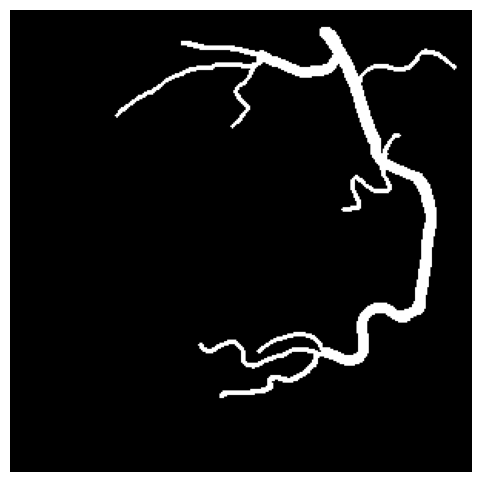

In [169]:
image_path = "img/7_gt.pgm"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Mostrar la imagen
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='gray')
plt.axis("off")
plt.show()

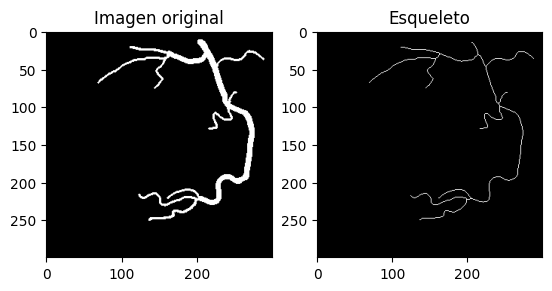

In [170]:
# otsu thresholding
_, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

skeleton = skeletonize(binary)

plt.subplot(1, 2, 1)
plt.title("Imagen original")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Esqueleto")
plt.imshow(skeleton, cmap='gray')

plt.show()

# coordenadas del esqueleto
skeleton_coords = np.column_stack(np.where(skeleton == 1))

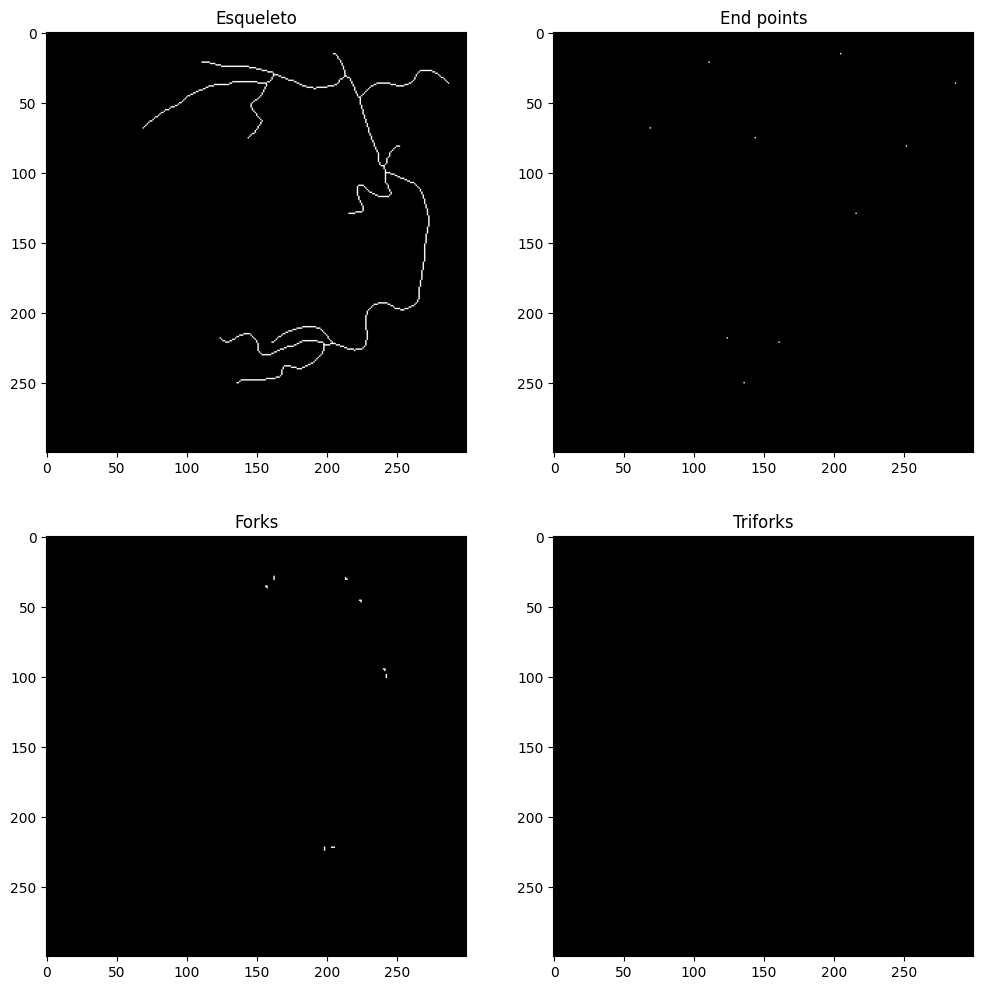

In [171]:
# Define the skeleton image (replace this with your actual skeleton image)
# skeleton = ...

# Define a kernel to count the number of neighbors
neighbor_kernel = np.array([[1, 1, 1],
                            [1, 10, 1],
                            [1, 1, 1]])

# Convolve the skeleton with the neighbor kernel
neighbor_count = convolve(skeleton.astype(np.uint8), neighbor_kernel, mode='constant', cval=0)

# Endpoints are pixels with exactly one neighbor (neighbor count == 11)
end_points = (neighbor_count == 11).astype(np.uint8)

# Forks are pixels with three or more neighbors (neighbor count >= 13)
fork_points = (neighbor_count == 13).astype(np.uint8)

# Triforks are pixels with exactly three neighbors (neighbor count == 13)
trifork_points = (neighbor_count >= 15).astype(np.uint8)

# Plot the results
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title("Esqueleto")
plt.imshow(skeleton, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("End points")
plt.imshow(end_points, cmap='gray', vmin=0, vmax=1)  # Ensure binary visualization

plt.subplot(2, 2, 3)
plt.title("Forks")
plt.imshow(fork_points, cmap='gray', vmin=0, vmax=1)  # Ensure binary visualization

plt.subplot(2, 2, 4)
plt.title("Triforks")
plt.imshow(trifork_points, cmap='gray', vmin=0, vmax=1)  # Ensure binary visualization

plt.show()

In [172]:
# obtener las coordenadas de los puntos finales, bifurcaciones y trifurcaciones
end_coords = np.column_stack(np.where(end_points == 1))
fork_coords = np.column_stack(np.where(fork_points == 1))
trifork_coords = np.column_stack(np.where(trifork_points == 1))

# filtrar las bifurcaciones que son trifurcaciones
for fork in fork_coords:
    for trifork in trifork_coords:
        if np.linalg.norm(fork - trifork) < 2:
            fork_coords = np.delete(fork_coords, np.where((fork_coords == fork).all(axis=1)), axis=0)
            break

# detectar coordenadas sin clasificar
intermediate_coords = []
for coord in skeleton_coords:
    if not any(np.array_equal(coord, end) for end in end_coords) and \
        not any(np.array_equal(coord, fork) for fork in fork_coords) and \
        not any(np.array_equal(coord, trifork) for trifork in trifork_coords):
        intermediate_coords.append(coord)

In [173]:
def any_nf_neighbor(coord, coords, path):
    for c in coords:
        if np.linalg.norm(coord - c) < 2 and not any(np.array_equal(c, p) for p in path):
            return c

In [174]:
def fork_neighbor(coord, fork, trifork):
    for f in fork:
        if np.linalg.norm(coord - f) < 2:
            return f
    for t in trifork:
        if np.linalg.norm(coord - t) < 2:
            return t

In [175]:
intermediate_paths = []
start_coords = np.vstack((end_coords, fork_coords, trifork_coords))
for end in start_coords:
    path = [end]
    coord = end
    while True:
        neighbor = any_nf_neighbor(coord, intermediate_coords, path)
        if neighbor is None:
            break
        path.append(neighbor)
        coord = neighbor

        f_neighbor = fork_neighbor(coord, fork_coords, trifork_coords)
        if f_neighbor is not None:
            if not np.array_equal(f_neighbor, end):
                path.append(f_neighbor)
                break
    intermediate_paths.append(path)

In [176]:
used_coords = set(tuple(coord) for path in intermediate_paths for coord in path)
unused_intermediate_coords = [coord for coord in intermediate_coords if tuple(coord) not in used_coords]
if unused_intermediate_coords and len(unused_intermediate_coords) > 1:
    intermediate_paths.append(unused_intermediate_coords)

C:\Users\euroc\AppData\Local\Temp\ipykernel_19344\366235993.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', len(intermediate_paths))


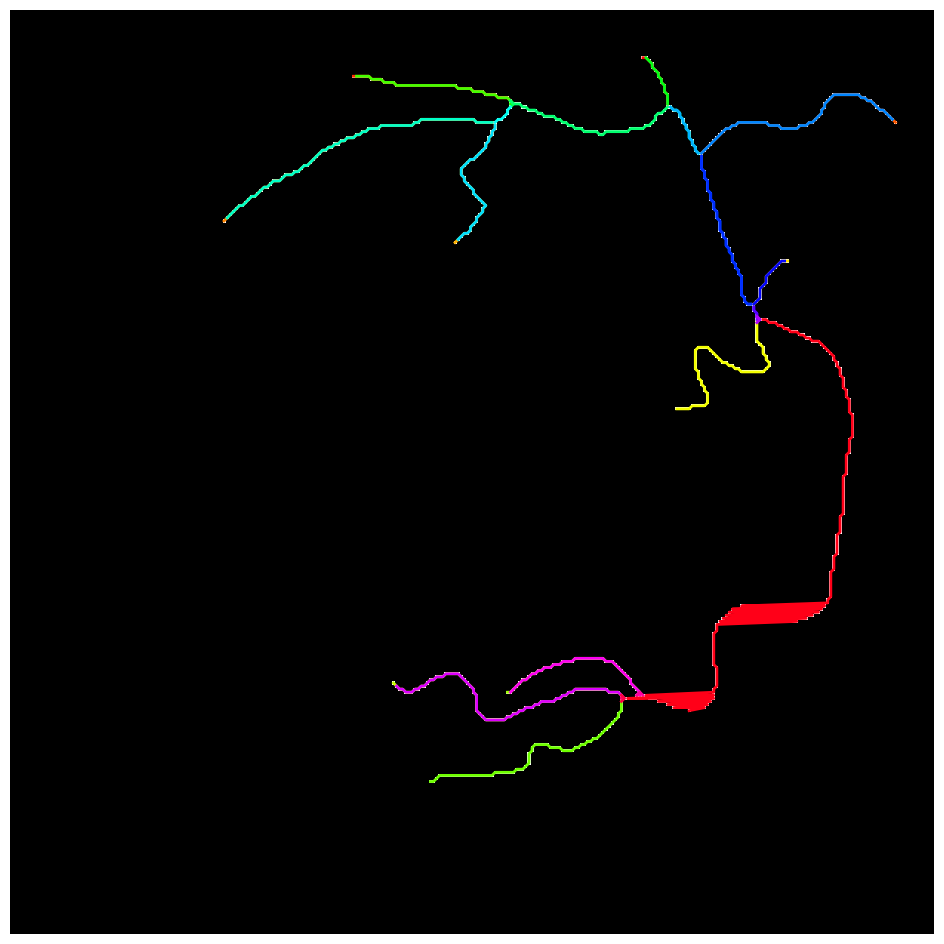

In [177]:
colors = plt.cm.get_cmap('hsv', len(intermediate_paths))

# Visualize the paths on the skeleton image
plt.figure(figsize=(12, 12))
plt.imshow(skeleton, cmap='gray', zorder=0)
plt.axis('off')

# Plot each path with a different color
for idx, path in enumerate(intermediate_paths):
    path = np.array(path)
    color = colors(idx)
    plt.plot(path[:, 1], path[:, 0], color=color, linewidth=2, zorder=1)

plt.show()

In [178]:
def path_variation(path):
    path = np.array(path)
    return np.linalg.norm(path[0] - path[-1]) + np.sum([np.linalg.norm(path[i] - path[i+1]) for i in range(len(path) - 1)])

In [179]:
intermediate_nodes = []
for path in intermediate_paths:
    if len(path) > 30:
        path_var = path_variation(path)

        if path_var > 90:
            if path_var > 500:
                path.sort(key=lambda p: (p[0], p[1]))
                
            node_quant = round(.075 * len(path))
            for i in range(0, len(path) - 1, int((len(path) - 1) / node_quant)):
                intermediate_nodes.append(path[i])
        else:
            q1 = int(len(path) / 2)
            q2 = int(len(path) / 4)
            intermediate_nodes.append(path[q1])
            intermediate_nodes.append(path[q2])
        
    elif len(path) > 5:
        q1 = int(len(path) / 2)
        intermediate_nodes.append(path[q1])


In [180]:
def delete_close_intermediate_nodes(nodes, intermediate_nodes, tresh = 2):
    for node in nodes:
        for inter in intermediate_nodes:
            if np.linalg.norm(node - inter) < tresh:
                intermediate_nodes = np.delete(intermediate_nodes, np.where((intermediate_nodes == inter).all(axis=1)), axis=0)
                break
    return intermediate_nodes

In [181]:
intermediate_nodes = delete_close_intermediate_nodes(fork_coords, intermediate_nodes)
intermediate_nodes = delete_close_intermediate_nodes(trifork_coords, intermediate_nodes)
intermediate_nodes = delete_close_intermediate_nodes(end_coords, intermediate_nodes)

In [182]:
def nearest_node(coord, nodes):
    nodes = np.array(nodes)
    if len(nodes) == 1:
        return nodes[0]
    nodes = np.delete(nodes, np.where((nodes == coord).all(axis=1)), axis=0)
    distances = np.linalg.norm(nodes - coord, axis=1)
    return nodes[np.argmin(distances)]

In [183]:
def score(node1, node2):
    var = np.var([node1[0], node2[0]]) + np.var([node1[1], node2[1]])
    node1 = np.array(node1)
    node2 = np.array(node2)
    dist = np.linalg.norm(node1 - node2)

    return dist + var


In [ ]:
# aristas
edges = []

arrays_to_merge = [end_coords, fork_coords, trifork_coords, intermediate_nodes]
non_empty_arrays = [arr for arr in arrays_to_merge if len(arr) > 0]
all_coords = np.vstack(non_empty_arrays)


valid_nodes = {tuple(coord) for coord in all_coords}
edges = []

for path in intermediate_paths:
    filtered_path = [tuple(coord) for coord in path if tuple(coord) in valid_nodes]
    

    if len(filtered_path) < 2:
        continue  

    for i in range(len(filtered_path) - 1):
        edges.append([filtered_path[i], filtered_path[i + 1]])  

edges = [edge for edge in edges if np.linalg.norm(np.array(edge[0]) - np.array(edge[1])) <= 100]
edges = [edge for edge in edges if abs(edge[0][0] - edge[1][0]) <= 50 and abs(edge[0][1] - edge[1][1]) <= 50]

# Asegurarse de que todas las coordenadas estén en formato lista
end_coords = end_coords.tolist()
fork_coords = fork_coords.tolist()
trifork_coords = trifork_coords.tolist()
intermediate_coords = [coord.tolist() for coord in intermediate_nodes]  # Convertir a lista
edges = [[list(map(int, edge[0])), list(map(int, edge[1]))] for edge in edges]


points_dict = {
    "end_points": end_coords,
    "fork_points": fork_coords,
    "trifork_points": trifork_coords,
    "intermediate_points": intermediate_coords,
    "edges": edges
}

# Guardar el diccionario en un archivo JSON
with open('outputs/points.json', 'w') as json_file:
    json.dump(points_dict, json_file, indent=4)


In [185]:
G = nx.Graph()

for end in end_coords:
    G.add_node(tuple(end), node_type='end', color='green')

for fork in fork_coords:
    G.add_node(tuple(fork), node_type='fork', color='red')

for trifork in trifork_coords:
    G.add_node(tuple(trifork), node_type='trifork', color='blue')

for intermediate in intermediate_coords:
    G.add_node(tuple(intermediate), node_type='intermediate', color='gray')

for edge in edges:
    G.add_edge(tuple(edge[0]), tuple(edge[1]))



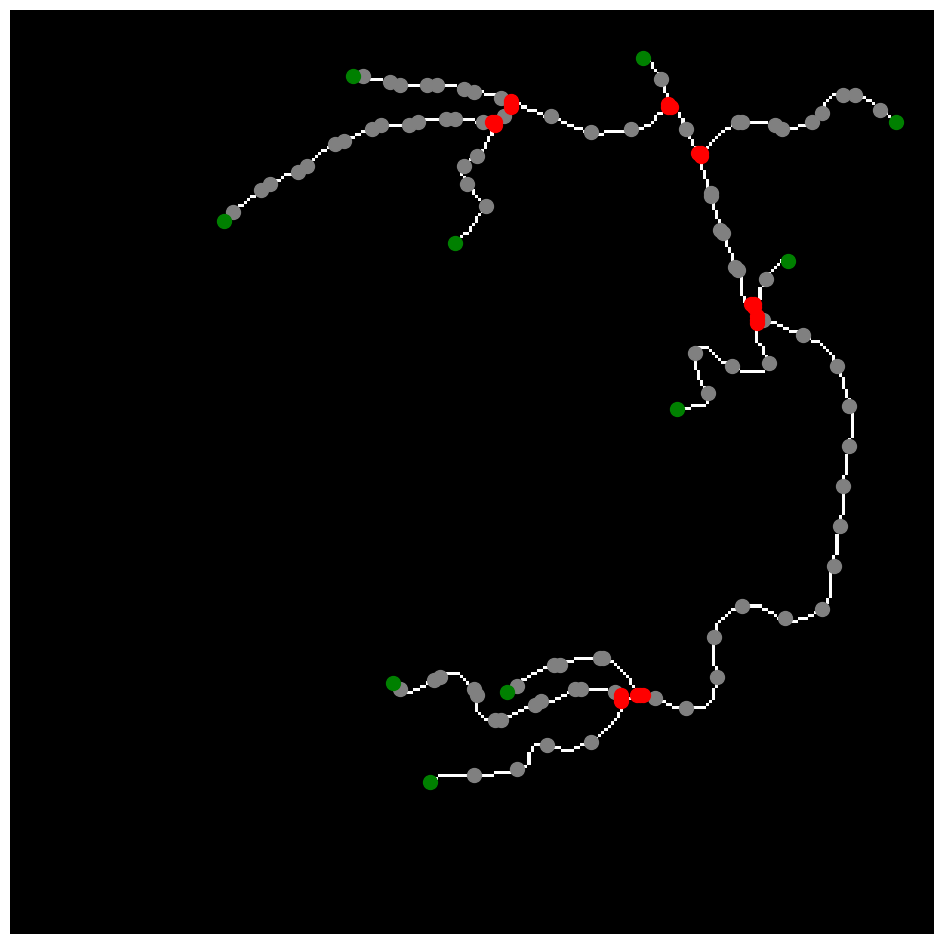

In [186]:
# Visualizar el grafo final sobre el esqueleto
plt.figure(figsize=(12, 12))
plt.imshow(skeleton, cmap='gray', zorder=0)
plt.axis('off')

# Plot de los nodos grises intermedios
for node in G.nodes(data=True):
    if 'color' in node[1]:
        if node[1]['color'] == 'gray':
            plt.scatter(node[0][1], node[0][0], c=node[1]['color'], s=100, zorder=1)

# Plot de las aristas
for edge in G.edges(data=True):
    plt.plot([edge[0][1], edge[1][1]], [edge[0][0], edge[1][0]], 'yellow', zorder=2)

# Plot de los nodos de otros colores
for node in G.nodes(data=True):
    if 'color' in node[1] and node[1]['color'] != 'gray':
        plt.scatter(node[0][1], node[0][0], c=node[1]['color'], s=100, zorder=3)

# Guardar la visualización final
plt.savefig('outputs/final_graph.png')
plt.show()